In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import copy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.metrics import Recall
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def functional_model(HEIGHT, WIDTH, outdim):
    # Define the input layer
    inputs = Input(shape=(HEIGHT, WIDTH, 3))

    # 첫번째 conv+pooling layer
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 두번째 conv+pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # 세번째 conv+pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'gradlayer')(x)

    
    x = Flatten()(x)

    # Dense layer with 512 units
    x = Dense(512)(x)
    x = Activation('relu')(x)

    # Output layer with softmax activation
    outputs = Dense(outdim, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [3]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
# from tensorflow.keras.models import Model

# def functional_model(HEIGHT, WIDTH, outdim):
#     # Define the input layer
#     inputs = Input(shape=(HEIGHT, WIDTH, 3))

#     # 첫번째 conv layer + pooling layer
#     x = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu')(inputs)
#     x = BatchNormalization()(x)  # 배치 정규화 추가
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)  # 드롭아웃 추가

#     # 두번째 conv layer + pooling layer
#     x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
#     x = BatchNormalization()(x)  # 배치 정규화 추가
#     x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
#     x = Dropout(0.25)(x)  # 드롭아웃 추가

#     # 세번째 conv layer + pooling layer
#     x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
#     x = BatchNormalization()(x)  # 배치 정규화 추가
#     x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='gradlayer')(x)
#     x = Dropout(0.25)(x)  # 드롭아웃 추가

#     # Flatten the output
#     x = Flatten()(x)

#     # Dense layer with 512 units
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)  # 드롭아웃 추가

#     # Output layer with softmax activation
#     outputs = Dense(outdim, activation='softmax')(x)

#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs)
#     return model


In [4]:
class project:
    def __init__(self, i, initial_path, HEIGHT, WIDTH, outdim, epochs):
        self.HEIGHT, self.WIDTH, self.outdim = HEIGHT, WIDTH, outdim
        # self.model = functional_model(self.HEIGHT, self.WIDTH, self.outdim)
        self.i = i
        self.epochs = epochs
        self.initial_path = initial_path
        self.early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링할 지표 (여기서는 검증 손실)
                               patience=4,          # 지정된 횟수만큼 개선이 없을 경우 훈련 중단
                               restore_best_weights=True)
        # ImageDataGenerator 설정
        self.datagen1 = ImageDataGenerator(
            rotation_range=3,
            width_shift_range=0.03,
            height_shift_range=0.03,
            brightness_range=[0.7, 1.0],
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest')
        self.datagen2 = ImageDataGenerator(
            rotation_range=3,
            width_shift_range=0.03,
            height_shift_range=0.03,
            brightness_range=[0.9, 1.1],
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest')  
        # rotation 각도를 키우는 것이 주효함

    def data_loader(self, path, final_num, gen):
                # 이미지 파일 확장자 (여기서는 jpg, jpeg, png로 가정)
        valid_image_extensions = ['.jpg', '.jpeg', '.png']

        # 해당 경로의 이미지 파일 목록 가져오기
        image_files = [f for f in os.listdir(path) if os.path.splitext(f)[1].lower() in valid_image_extensions]

        # 이미지를 저장할 리스트
        image_list = []

        # 각 이미지 파일에 대해 반복
        for image_file in image_files:
            # 이미지 파일 경로
            image_path = os.path.join(path, image_file)

            # 이미지 불러오기 (OpenCV를 사용하여)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = image.astype('float32')
            # image = image[50:300, 200:450]
            # image = cv2.resize(image, (self.WIDTH, self.HEIGHT))
            image_list.append(image) # cv2리스트

        # 이미지 리스트를 NumPy 배열로 변환하여 반환
            
        image_batch = copy.deepcopy(image_list)

        m = []
        for i in range(0, final_num):
            k = random.randint(0, len(image_batch)-1)
            m.append(k)

        image_batch_ = copy.deepcopy(image_batch)

        aug = []
        for i in m:
            img = image_batch_[i]
            img_augmented = gen.random_transform(img)
            img_augmented = img_augmented.astype(np.uint8)
            aug.append(img_augmented)

        all = image_batch + aug
        return all, image_batch, aug
        # 'image_batch' : 원본 / 'aug' : 증강된 데이터 / 'all' : 순서대로 원본+증강 

    def data_encoder(self, final_num_seal, final_num_unsealed):
        all_seal, image_batch_seal, aug_seal = self.data_loader(os.path.join(self.initial_path, os.listdir(self.initial_path)[0]), final_num_seal, self.datagen1)
        all_unsealed, image_batch_unsealed, aug_unsealed = self.data_loader(os.path.join(self.initial_path, os.listdir(self.initial_path)[1]), final_num_unsealed, self.datagen2)
        # all_seal_np = np.array(all_seal)/255
        # all_unsealed_np = np.array(all_unsealed)/255
        # image_all = np.concatenate((all_seal_np, all_unsealed_np), axis=0)
        
        # array_1 = np.array([[1, 0]] * final_num_seal)
        # array_0 = np.array([[0, 1]] * final_num_unsealed)
        # label_all = np.concatenate((array_1, array_0), axis=0)
        aug_seal_np = np.array(aug_seal)/255
        aug_unsealed_np = np.array(aug_unsealed)/255
        image_all = np.concatenate((aug_seal_np, aug_unsealed_np), axis=0)
        height1 ,height2, width1, width2 = 50, 300, 200, 500
        image_all = image_all[:, height1:height2, width1:width2, :]        
        array_1 = np.array([[1, 0]] * final_num_seal)
        array_0 = np.array([[0, 1]] * final_num_unsealed)
        label_all = np.concatenate((array_1, array_0), axis=0)
        # 데이터를 훈련 세트(80%)와 테스트 세트(20%)로 나누기
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(image_all, label_all, test_size=0.2, random_state=42)

        # 나머지 데이터를 검증 세트(25%)와 테스트 세트(75%)로 나누기
        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        
    def train(self, model):
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        epoch = self.epochs
        batch_size = 64

        # validation_data 매개변수를 사용하여 검증 세트를 지정
        self.History = model.fit(self.X_train, self.y_train, epochs=epoch,
                            batch_size=batch_size, shuffle=True,
                            validation_data=(self.X_valid, self.y_valid), 
                            callbacks=[self.early_stopping],
                            verbose=1).history

    def confusion_matrix(self):
        pass

    def gradcam(self, img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] 
        heatmap = tf.squeeze(heatmap)  # 축 쥐어짜서 (squeeze) 없애주기 ([높이, 너비, 1] -> [높이, 너비]가 됨)
        max_val = tf.math.reduce_max(heatmap)
        if max_val == 0:
            max_val = 1e-10  # 매우 작은 값을 사용하여 나누기 오류 방지
        heatmap = tf.maximum(heatmap, 0) / max_val
        return heatmap
    
    def subplot(self, model, n):

        heatmap = self.gradcam(self.X_test[n:n+1], model, 'gradlayer')

        # 가로로 두 개의 서브플롯 생성
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # 첫 번째 서브플롯에 그래프 그리기
        ax1.imshow(heatmap)
        ax1.set_title('heatmap')

        # 두 번째 서브플롯에 그래프 그리기
        ax2.imshow(self.X_test[n])
        ax2.set_title('Image')

        # 레이아웃 조정 및 그래프 표시
        plt.tight_layout()
        plt.show()
        #plt.savefig('subplot{}.png'.format(n))

    # loss plot graph. history의 훈련 과정에서 loss의 추세를 보여줌
    def loss_plot(self):
        plt.plot(self.History['loss'])
        plt.plot(self.History['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['train', 'vaild'])
        plt.yscale('log')
        plt.show()

In [5]:
# 객체 생성
initial_path = '../cleandata/(5)'
outdim = 2
PROJECT = project(2, initial_path, 250, 300, outdim, 10)
# 데이터를 불러오는 작업
PROJECT.data_encoder(1000, 1000)
model = functional_model(250, 300, outdim)
PROJECT.train(model)

2024-01-11 14:24:01.425922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:24:02.378675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22299 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-01-11 14:24:02.379235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22300 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-01-11 14:24:02.379612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0

Epoch 1/10


2024-01-11 14:24:04.859241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2024-01-11 14:24:05.427313: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 14:24:06.266191: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 4s 61ms/step - loss: 0.7308 - accuracy: 0.7231 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 1s 51ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.8842e-08 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 1s 50ms/step - loss: 2.5069e-08 - accuracy: 1.0000 - val_loss: 1.5525e-09 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 1s 51ms/step - loss: 1.7809e-08 - accuracy: 1.0000 - val_loss: 1.2622e-09 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 1s 49ms/step - loss: 1.7080e-08 - accuracy: 1.0000 - val_loss: 1.2412e-09 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 1s 52ms/step - loss: 1.6746e-08 - accuracy: 1.0000 - val_loss: 1.2387e-09 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 1s 51ms/step - loss: 1.6218e-08 - accuracy: 1.0000 - val_loss: 1.2390e-09 - v

In [6]:
PROJECT = project(2, initial_path, 250, 300, outdim, 10)
PROJECT.data_encoder(1000, 1000)
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    model = functional_model(250, 300, outdim)
    PROJECT.train(model)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-01-11 14:26:22.169116: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2255"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 64
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/t

2024-01-11 14:26:26.411717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2024-01-11 14:26:27.444040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


25/25 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.8369

2024-01-11 14:26:33.227353: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_5306"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

25/25 [==============================] - 13s 146ms/step - loss: 0.5620 - accuracy: 0.8369 - val_loss: 8.8898e-05 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 2s 77ms/step - loss: 2.7549e-05 - accuracy: 1.0000 - val_loss: 9.8782e-08 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 2s 77ms/step - loss: 7.7297e-08 - accuracy: 1.0000 - val_loss: 5.8568e-08 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 2s 77ms/step - loss: 5.9251e-08 - accuracy: 1.0000 - val_loss: 5.2504e-08 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 2s 78ms/step - loss: 5.5087e-08 - accuracy: 1.0000 - val_loss: 4.9599e-08 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 2s 77ms/step - loss: 5.1805e-08 - accuracy: 1.0000 - val_loss: 4.6183e-08 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 2s 77ms/step - loss: 4.7816e-08 - accuracy: 1.0000 - val_loss: 4.24

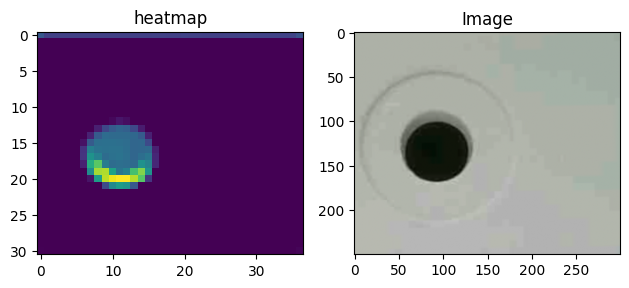

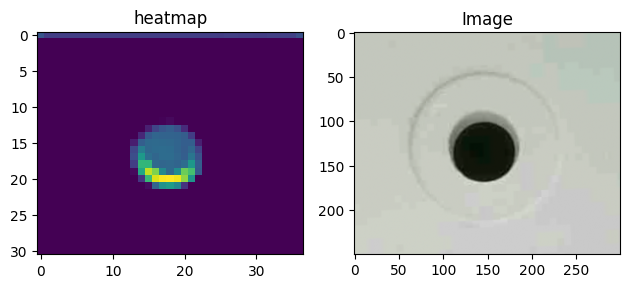

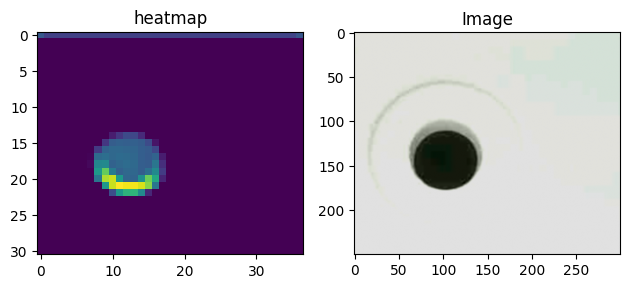

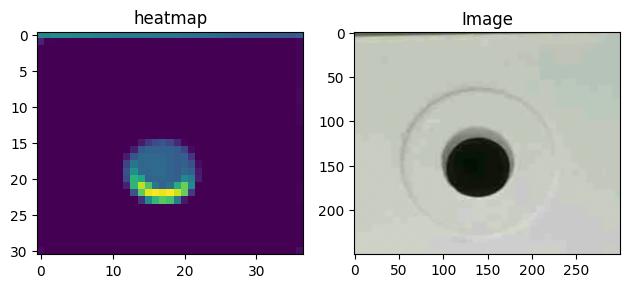

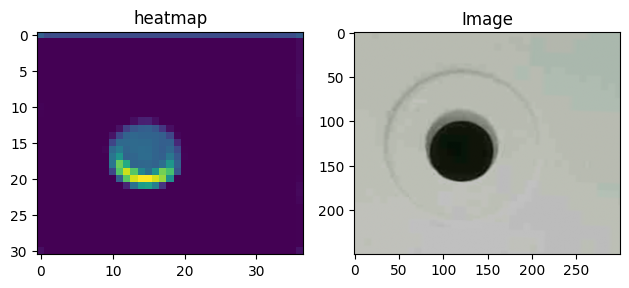

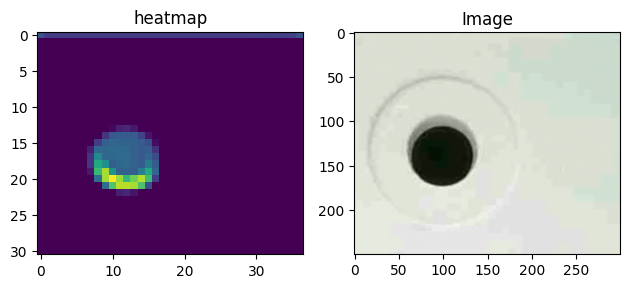

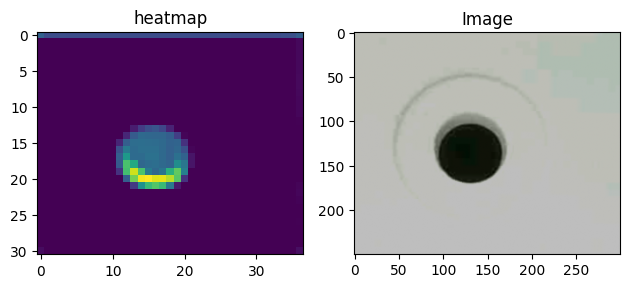

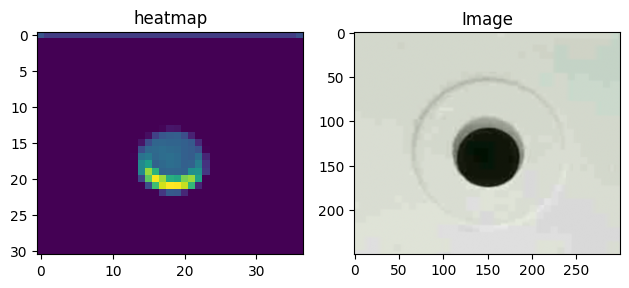

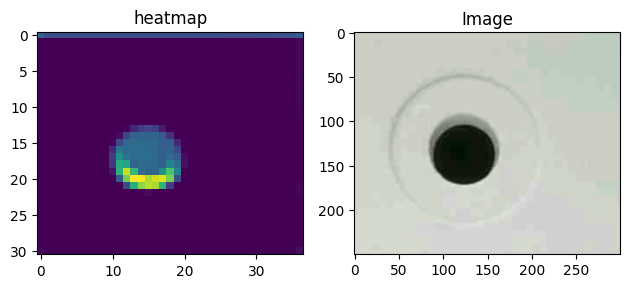

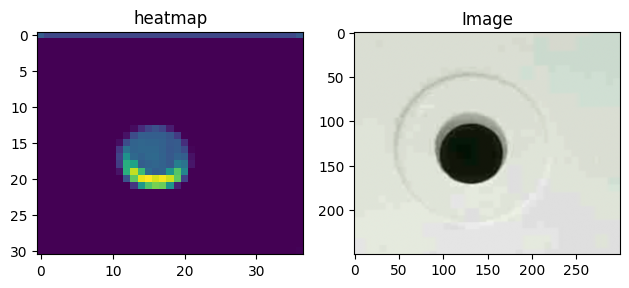

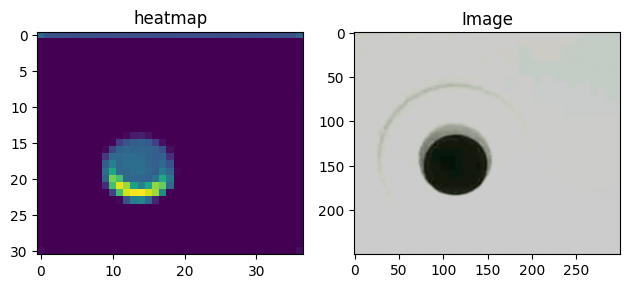

In [41]:
indices = np.where(PROJECT.y_test[:, 1] == 0)[0]
n=0
for index in indices:
    PROJECT.subplot(index)
    n=n+1
    if n>10:
        break

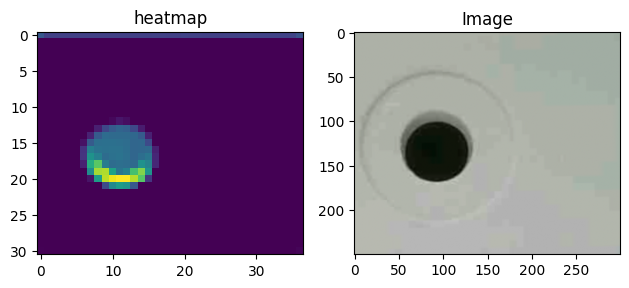

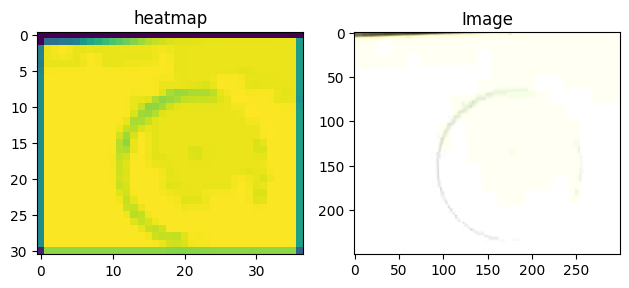

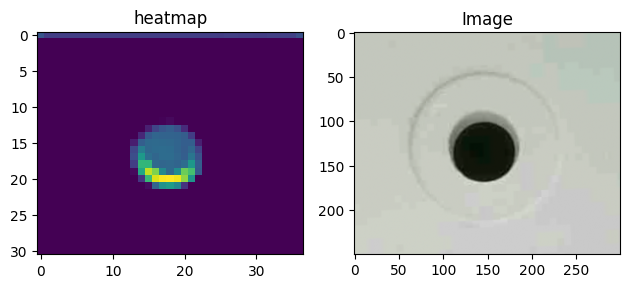

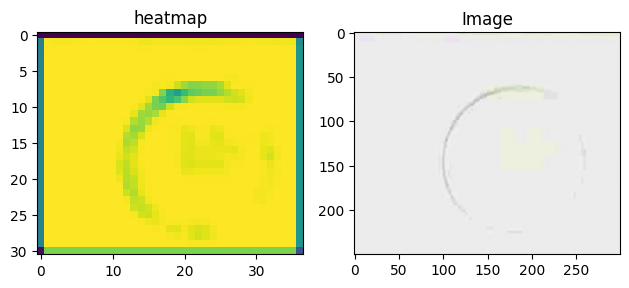

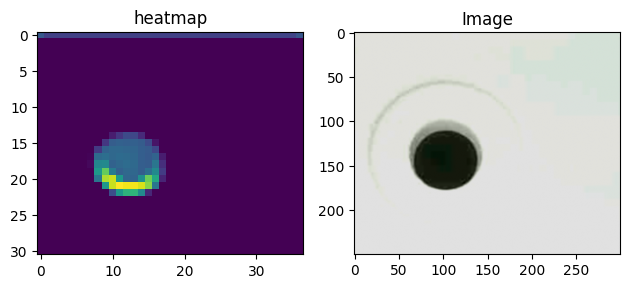

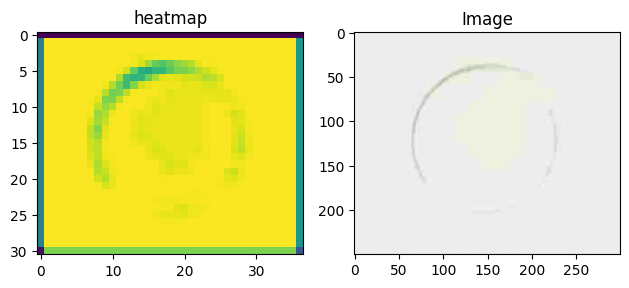

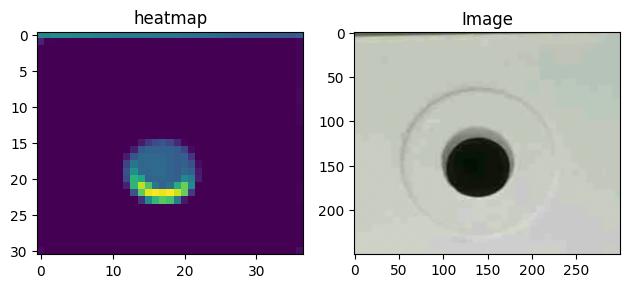

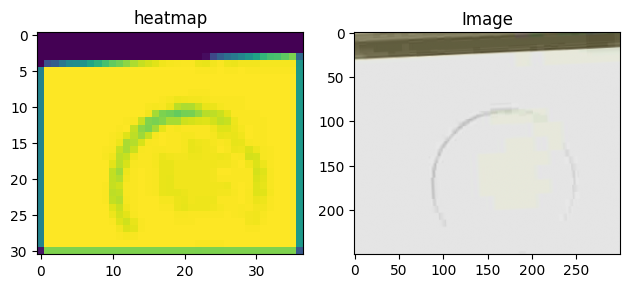

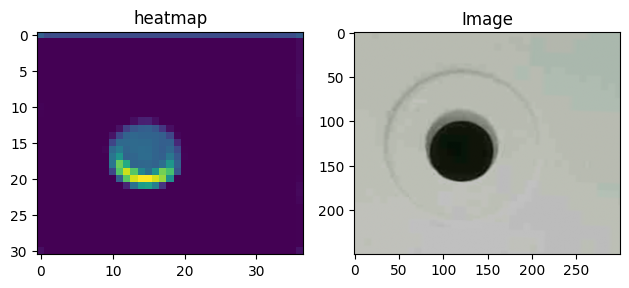

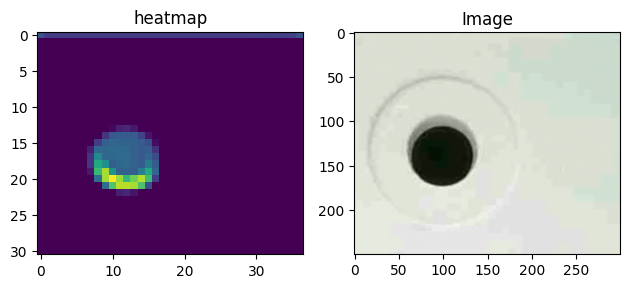

In [42]:
for i in range(10):
    PROJECT.subplot(i)